# Setup

- ### Install Dependencies

In [1]:
!pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python matplotlib

ERROR: Could not find a version that satisfies the requirement tensorflow==2.4.1 (from versions: 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2)
ERROR: No matching distribution found for tensorflow==2.4.1


- ### Import Dependencies

In [2]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [3]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

- ### Set GPU Growth

In [4]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
len(gpus)

0

- ### Create Folder Structures

In [6]:
# Setup paths - joins repos 
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [32]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

## Collect Positives and Anchors

- ### untar labelled faces in the wild ds

In [ ]:
!tar -xf lfw.tgz

In [ ]:
#move lfw images to the negative repo
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH,NEW_PATH)

- ### collecting positive & anchor classes - via access of webcam

In [27]:
# importing uuid library to generate unique image names 
import uuid # universally unique identifier library 

In [36]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
# this provides a unique id to the image captured & getting placed over the specified repos

'data\\anchor\\7b6033d1-130e-11ee-8cba-84a938bd3327.jpg'

In [54]:
# accessing of the web-cam
cap = cv2.VideoCapture(0)
# loop thorough every frame of cam
while cap.isOpened():
    ret, frame = cap.read() # read the capture at the time - unpacking of the result
    
    #only capture 250x250px
    frame = frame[120:120+250,200:200+250 ,:]

    # collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # creatign a unique file name
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # write out anchor image with the name
        cv2.imwrite(imgname, frame)

    # collect positives 
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # creatign a unique file name
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # write out anchor image with the name
        cv2.imwrite(imgname, frame)

    cv2.imshow('Image Collection', frame) # rendering the image back at the screen 


    if cv2.waitKey(1) & 0XFF == ord('q'): # breaking gracefully wait for 1ms. AND unpack what key is pressed ( to esc press 'q') 
        break
# release our web-camq
cap.release()
# close the webcam window
cv2.destroyAllWindows()


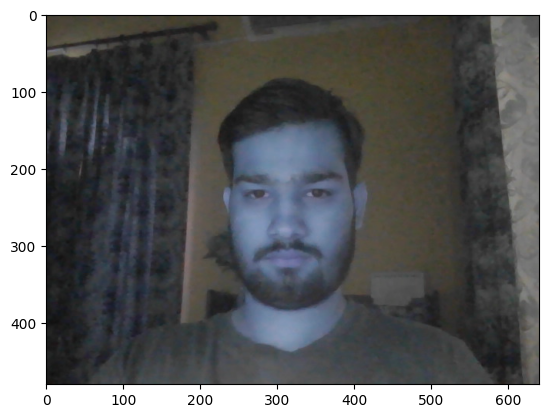

In [56]:
# this is the result from the abv code
plt.imshow(frame)


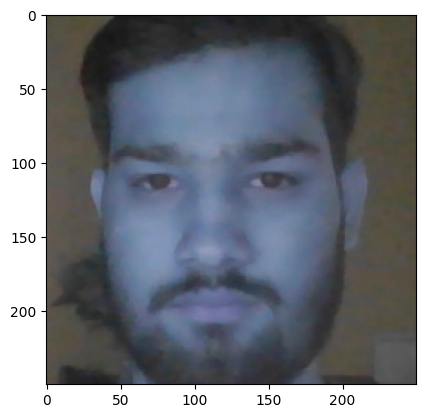

In [55]:
# the input frame size (not 250 x 250) which we need 
frame.shape # -> (480, 640, 3)

#applying slicing over the image to make it 250x250 (the training ds size)
frame[:250, :250 ,:].shape # -> (250, 250, 3)

# plt.imshow(frame[:250, :250 ,:]) # we will get the sliced top-right corner 
plt.imshow(frame[120:120+250,200:200+250 ,:]) # this will center up the slice roughly


# PreProcessing - Preparing data for deep learning

- ### Get image directories

In [48]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300) # extract everything frome the anchor repo, which has a .jpg extension
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(300)

In [49]:
dir_test = anchor.as_numpy_iterator()

In [77]:
dir_test.next()

b'data\\anchor\\b11fd0c7-130f-11ee-aeef-84a938bd3327.jpg'

- ### Preprocessing - Scale & Resize 

In [60]:
# loads our image, resize it for us 
def preprocess (file_path): 
    #load up the byte map of the image from the file_path - readin the image
    byte_img = tf.io.read_file(file_path)
    # decodes the image from the byte map 
    img = tf.io.decode_jpeg(byte_img)
    #resizing of the image (preprocessing )
    img = tf.image.resize(img, (100,100))
    # preforming the scalling over the image to be between (0,255) ( preprocessing )
    img = img / 255.0
    return img
# this function will return a numpy equvalent mappingof the image 

In [78]:
img = preprocess('data\\anchor\\86803bca-130f-11ee-955f-84a938bd3327.jpg')

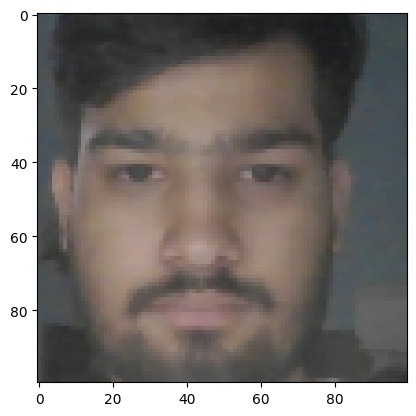

In [79]:
plt.imshow(img)


- ### creating a labelled dataset

In [82]:
# (anchor , positive) => 1,1,1,1,1,1
# (anchor , negative) => 0,0,0,0,0,0

In [150]:
# anchor_image ( the test image ) , postive_image , 1
positives = tf.data.Dataset.zip((anchor,positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
# anchor_image ( the test image ) , negative_image , 0

negatives = tf.data.Dataset.zip((anchor,negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [152]:
data

<ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [153]:
class_labels = tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))

In [154]:
samples = data.as_numpy_iterator()

In [155]:
eg = samples.next()
eg

(b'data\\anchor\\b26be3ea-130f-11ee-b4f7-84a938bd3327.jpg',
 b'data\\positive\\34e2daa2-1310-11ee-a5a2-84a938bd3327.jpg',
 1.0)

- ### Building Train & Train Partition

In [156]:
def preprocess_twin(input_img, validation_img, label ):
    return(preprocess(input_img), preprocess(validation_img), label)

In [157]:
res = preprocess_twin(*eg) # the star destructures the data

In [159]:
# building up dataloader pipeline -  tensorflow pipeline
# running twin data preprocessing over the entire ds
data = data.map(preprocess_twin)
# caching our images
data = data.cache()
#shuffling our images 
data = data.shuffle(buffer_size=1024)

0.0

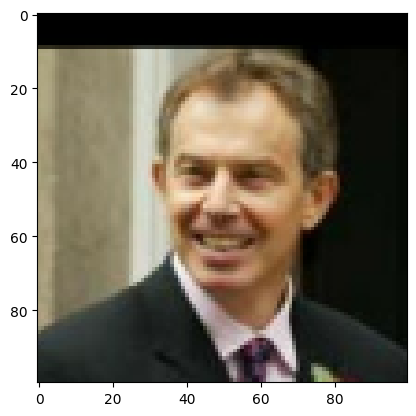

In [190]:
samples = data.as_numpy_iterator()
samp = samples.next()
plt.imshow(samp[1]) # negative / positive image 
samp[2] # labelled 0/1 


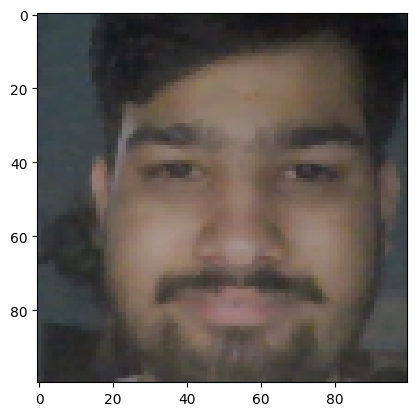

In [191]:
plt.imshow(samp[0]) # paired anchor image

In [192]:
# training & testing partition
# gradding 70% of the data to train
train_data = data.take(round(len(data)*.7))
# diviging the data into batches of 16
train_data = train_data.batch(16)
# start preprocessing the next set of data over the NN, when we train 
train_data = train_data.prefetch(8)

In [195]:
train_samples = train_data.as_numpy_iterator()
train_sample = train_samples.next()
len(train_sample[0]) # there are 16 images in the set of each sample set

16

In [199]:
# testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [200]:
test_samples = test_data.as_numpy_iterator()
test_sample = test_samples.next()
len(test_sample[0]) # there are 16 images in the set of each sample set

16